# Time Series - `VAR` model

## What does `statsmodels` include?

"statsmodels" is a comprehensive Python package for statistical modeling and econometrics, offering features such as:

+ Linear regression, generalized linear models (GLM), and Bayesian regression

+ Time series models: `AR`, `MA`, `ARMA`, `ARIMA`, `SARIMA`, `SARIMAX`, `VAR`, `ARCH`, `GARCH`

+ Descriptive statistics and statistical hypothesis testing

+ Tools for autocorrelation analysis: `ACF`, `PACF`, and stationarity tests like the `Dickey-Fuller test`

# What is the `VAR` model?

## Definition:

A `VAR` **(Vector Autoregression)** model is a statistical model used to capture the linear relationships between multiple time series that influence each other over time.

Unlike univariate models (like ARIMA), VAR handles multiple interdependent time series simultaneously.

## Components:

+ **Endogenous variables**: The time series being modeled (e.g., heater sales and ice cream sales).

+ **Lagged values**: Each variable is regressed on its `own past values` and `the past values of all other variables`.

+ **Lag order** `(p)`: Number of previous time steps considered in the model.

# `ice_cream` vs `heater` data project
## Dataset description:
This project is based on a dataset originally shared by GitHub user [ritvikmath](https://github.com/ritvikmath). The data was used as the foundation for exploring a custom implementation of a `VAR` (Vector Autoregression) model and conducting time series analysis in Python.


The dataset contains monthly sales data for two seasonal products - heaters and ice creams - starting from January 2004. It consists of the following columns:

+ `Month` (string, format: YYYY-MM):

Represents the year and month of the recorded data point.

+ `heater` (integer):

The number of heaters sold in that month. Higher values are typically observed in colder months.

+ `ice cream` (integer):

The number of ice creams sold in that month. Higher values are typically observed in warmer months.

## Import the libraries:

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

## Read the data:

In [78]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater/ice_cream_vs_heater.csv')
ice_cream_heater_df.head()

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21


## Month `to_datatime()` index and `asfreq()`:

In [79]:
ice_cream_heater_df['Month'] = pd.to_datetime(ice_cream_heater_df['Month'], format='%Y-%m')
ice_cream_heater_df.set_index('Month', inplace=True)

In [80]:
ice_cream_heater_df.head()

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


In [81]:
ice_cream_heater_df = ice_cream_heater_df.asfreq(freq='MS')

In [82]:
ice_cream_heater_df.head()

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


In [83]:
ice_cream_heater_df.tail()

,heater,ice cream
Month,,
2020-02-01,34,45
2020-03-01,25,44
2020-04-01,25,53
2020-05-01,27,70
2020-06-01,24,74


## Visualization of the raw time series:

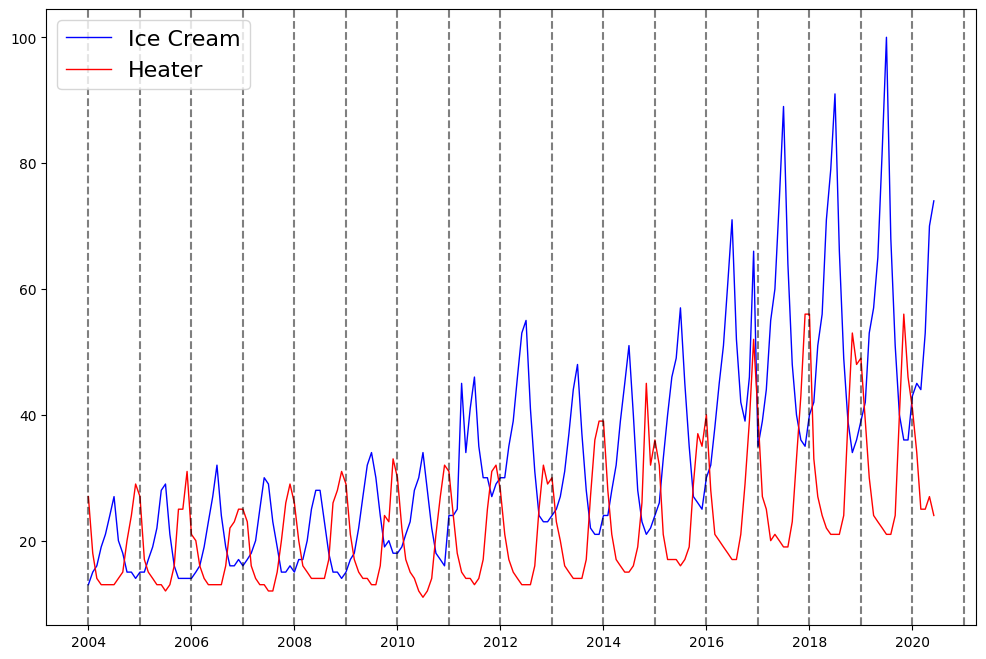

In [84]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Data scaling:
+ VAR is based on regression coefficients, which are highly sensitive to differences in scale between variables.

+ If one variable (e.g., ice cream sales) ranges from 10 to 100, while another (e.g., heater sales) ranges from 0 to 30, the model may assign disproportionate importance to the first variable simply because its values are larger.

+ This distorts the interpretation and can lead to inaccurate results in forecasting, impact analysis, or Granger causality testing.

+ For example, we can use Z-score, IQR, or normalization

### Standardization (Z-score):
$$z = \frac{x - \mu}{\sigma}$$

+ $x$ - original value


+ $μ$ – mean


+ $σ$ – standard deviation


+ $z$ – standardized value (Z-score)


In [85]:
mean = ice_cream_heater_df.mean()
deviation = ice_cream_heater_df.std()

In [86]:
print('Mean: \n', mean)
print('\nStandard deviation: \n', deviation)

Mean: 
 heater       22.792929
ice cream    33.060606
dtype: float64

Standard deviation: 
 heater        9.795500
ice cream    17.073635
dtype: float64


In [87]:
print(mean['heater'])

22.792929292929294


In [88]:
for column in ice_cream_heater_df.columns:
    ice_cream_heater_df[column] = (ice_cream_heater_df[column] - mean[column])/deviation[column]

## Visualization of the time series after standardization:

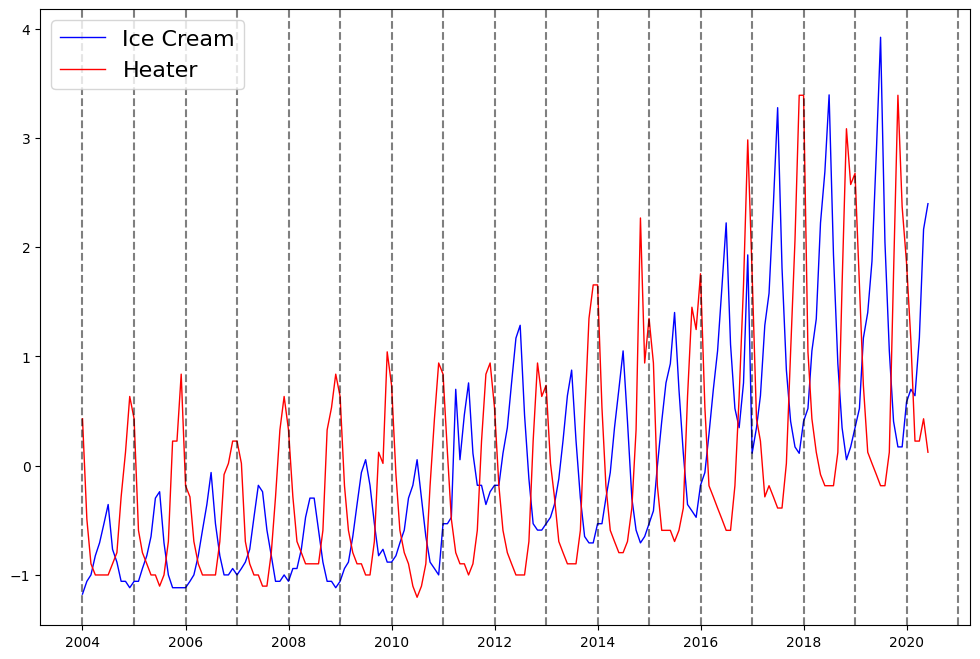

In [89]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Is data not stationary? - ADF (Augmented Dickey-Fuller) test:

We use ADF (Augmented Dickey-Fuller) tests, which are designed to assess the stationarity of a time series.

It tests the following hypotheses:

+ H₀ (null hypothesis): the series is not stationary (contains a unit root, i.e., has a trend).

+ H₁ (alternative hypothesis): the series is stationary.

By analyzing the test statistic and the corresponding p-value, we can determine whether to reject the null hypothesis and conclude that the series is stationary.

In [90]:
from statsmodels.tsa.stattools import adfuller

results = []

for column in ice_cream_heater_df.columns:
    test_result = adfuller(ice_cream_heater_df[column])
    results.append((column, test_result[0], test_result[1]))

print("ADF Test Results:\n")

for var, adf_stat, p_val in results:
    print(f"{var:<12} | ADF Statistic: {adf_stat:.4f} | p-value: {p_val:.4f}")

ADF Test Results:

heater       | ADF Statistic: 0.9501 | p-value: 0.9937
ice cream    | ADF Statistic: -0.3039 | p-value: 0.9249


$p-value > alfa = 0.05$

We accept the null hypothesis $H_{0}$ - The series are not stationary

## Data is not stationary - `.diff().dropna()`:

In [91]:
ice_cream_heater_df = ice_cream_heater_df.diff().dropna()

## Is data not stationary? - ADF (Augmented Dickey-Fuller) test:

We use ADF (Augmented Dickey-Fuller) tests, which are designed to assess the stationarity of a time series.

It tests the following hypotheses:

+ H₀ (null hypothesis): the series is not stationary (contains a unit root, i.e., has a trend).

+ H₁ (alternative hypothesis): the series is stationary.

By analyzing the test statistic and the corresponding p-value, we can determine whether to reject the null hypothesis and conclude that the series is stationary.

In [92]:
from statsmodels.tsa.stattools import adfuller

results = []

for column in ice_cream_heater_df.columns:
    test_result = adfuller(ice_cream_heater_df[column])
    results.append((column, test_result[0], test_result[1]))

print("ADF Test Results:\n")

for var, adf_stat, p_val in results:
    print(f"{var:<12} | ADF Statistic: {adf_stat:.5f} | p-value: {p_val:.5f}")

ADF Test Results:

heater       | ADF Statistic: -16.96731 | p-value: 0.00000
ice cream    | ADF Statistic: -4.78172 | p-value: 0.00006


$p-value < alfa = 0.05$

We reject the null hypothesis $H_{0}$ - The series are stationary

## Visualization of the time series after differencing:

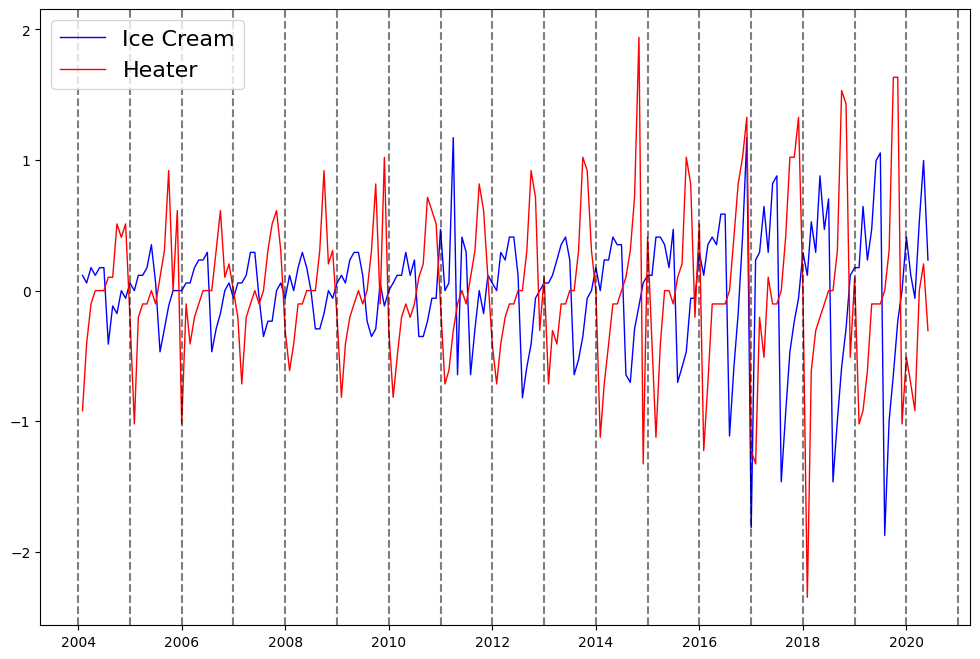

In [93]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

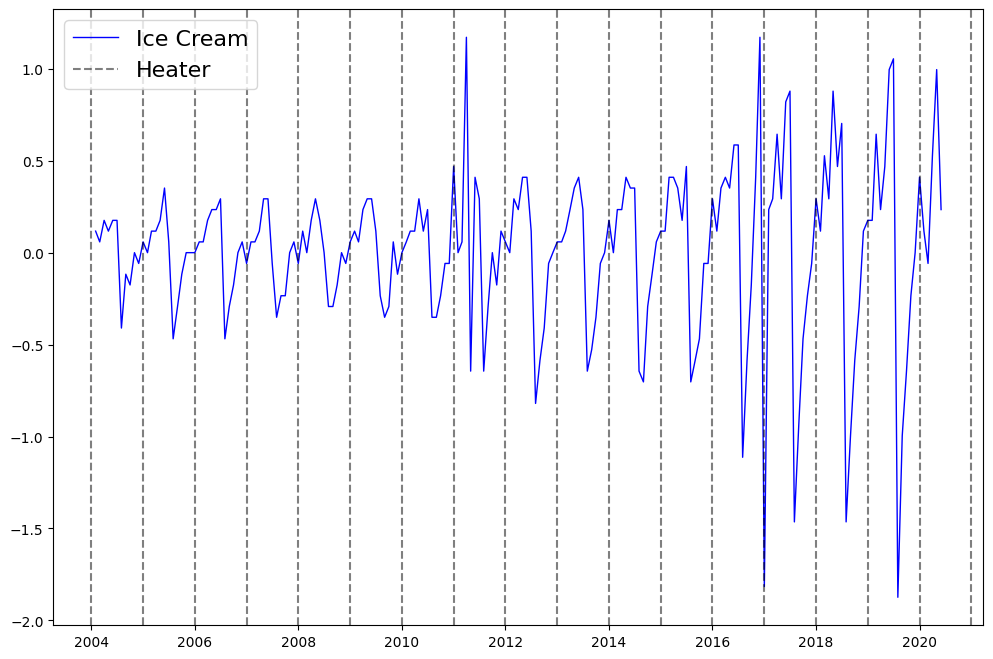

In [94]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Remove Increasing Volatility

**Heteroscedasticity** is a situation where the variance (or spread) of the variables changes over time - in other words, the data exhibit non-constant variability. `VAR`, `ARIMA`, and regression models often assume constant error variance (homoscedasticity). When this condition is not met, the resulting forecasts may be inaccurate or misleading.
+ For example, the time series may appear calm at the beginning, but later the amplitude increases significantly - this indicates heteroscedasticity.

### Methods to address this issue:
+ **Log transformation** – useful when variance increases proportionally to the values.
+ **Box-Cox transformation** – helpful when the optimal transformation is not known in advance.
+ **Variance stabilization** - before modeling – improves residual accuracy and increases forecast reliability.


In [95]:
annual_volatility = ice_cream_heater_df.groupby(ice_cream_heater_df.index.year).std()

In [96]:
annual_volatility

,heater,ice cream
Month,,
2004,0.415481,0.184201
2005,0.474527,0.214837
2006,0.400148,0.227698
2007,0.359839,0.198947
2008,0.396182,0.183239
2009,0.499810,0.221038
2010,0.459566,0.211668
2011,0.443924,0.501018
2012,0.471104,0.389711


In [97]:
ice_cream_heater_df['ice_cream_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'ice cream'])
ice_cream_heater_df['heater_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'heater'])

In [98]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
2004-02-01,-0.918789,0.117140,0.184201,0.415481
2004-03-01,-0.408351,0.058570,0.184201,0.415481
2004-04-01,-0.102088,0.175710,0.184201,0.415481
2004-05-01,0.000000,0.117140,0.184201,0.415481
2004-06-01,0.000000,0.175710,0.184201,0.415481
...,...,...,...,...
2020-02-01,-0.714614,0.117140,0.369810,0.426657
2020-03-01,-0.918789,-0.058570,0.369810,0.426657
2020-04-01,0.000000,0.527129,0.369810,0.426657


In [99]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] / ice_cream_heater_df['ice_cream_annual_vol']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] / ice_cream_heater_df['heater_annual_vol']

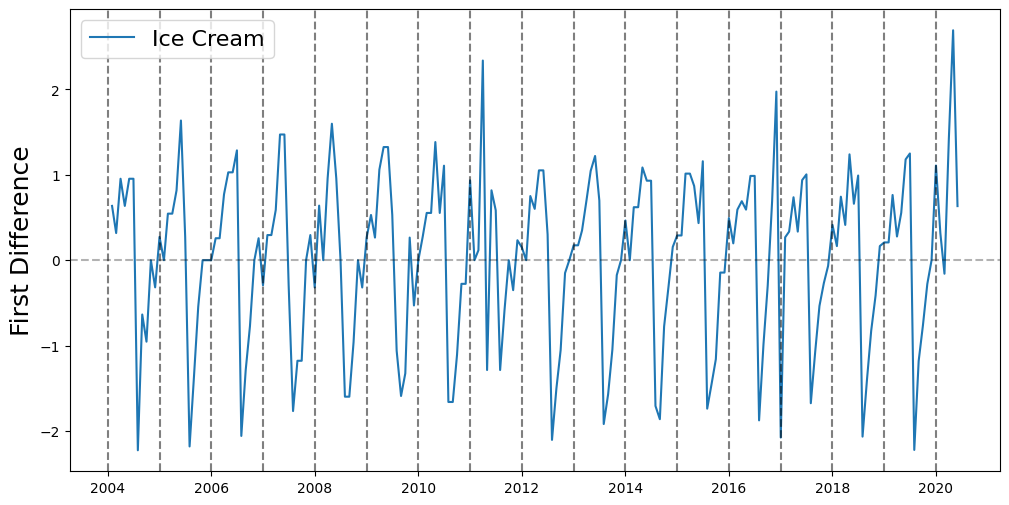

In [100]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

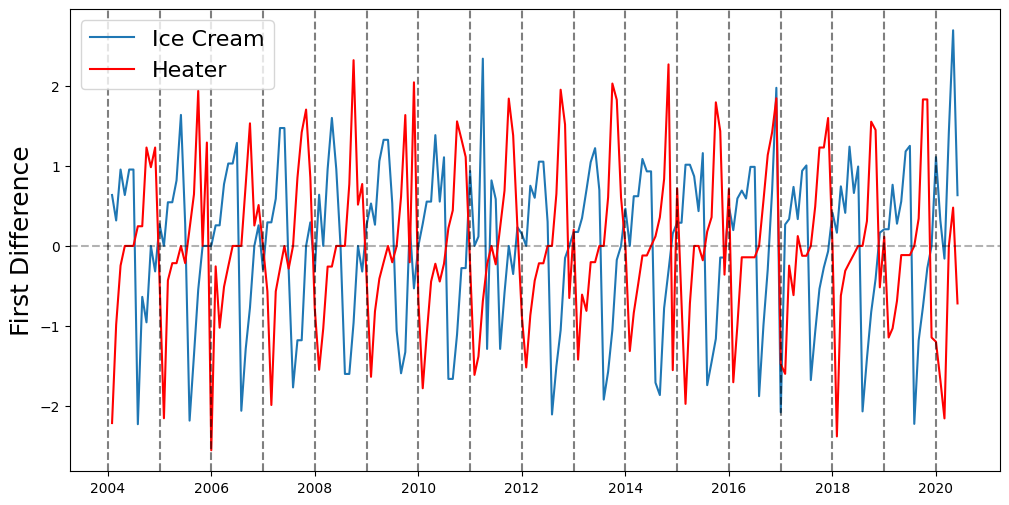

In [101]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# Remove Seasonality

In [102]:
chlep

month_avgs = ice_cream_heater_df.groupby(ice_cream_heater_df.index.month).mean()

NameError: name 'chlep' is not defined

In [461]:
print(month_avgs)

         heater  ice cream  ice_cream_annual_vol  heater_annual_vol
Month                                                              
1     -0.428360   0.130345              0.415976           0.580717
2     -1.483129   0.250194              0.402342           0.570997
3     -1.063595   0.433016              0.402342           0.570997
4     -0.442926   0.838085              0.402342           0.570997
5     -0.121663   0.967273              0.402342           0.570997
6     -0.128425   0.987311              0.402342           0.570997
7     -0.107093   0.735052              0.404376           0.580018
8      0.075720  -1.821285              0.404376           0.580018
9      0.544638  -1.307661              0.404376           0.580018
10     1.613170  -0.830889              0.404376           0.580018
11     1.183118  -0.088136              0.404376           0.580018
12     0.491641   0.088998              0.404376           0.580018


In [462]:
ice_cream_heater_df['ice_cream_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'ice cream'])
ice_cream_heater_df['heater_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'heater'])

In [463]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-2.211387,0.635934,0.184201,0.415481,0.250194,-1.483129
2004-03-01,-0.982838,0.317967,0.184201,0.415481,0.433016,-1.063595
2004-04-01,-0.245710,0.953901,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.000000,0.635934,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.000000,0.953901,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-1.674916,0.316756,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-2.153463,-0.158378,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.000000,1.425403,0.369810,0.426657,0.838085,-0.442926


In [464]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] - ice_cream_heater_df['ice_cream_month_avg']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] - ice_cream_heater_df['heater_month_avg']

In [465]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-0.728257,0.385740,0.184201,0.415481,0.250194,-1.483129
2004-03-01,0.080757,-0.115049,0.184201,0.415481,0.433016,-1.063595
2004-04-01,0.197217,0.115816,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.121663,-0.331339,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.128425,-0.033411,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-0.191787,0.066562,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-1.089868,-0.591394,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.442926,0.587318,0.369810,0.426657,0.838085,-0.442926


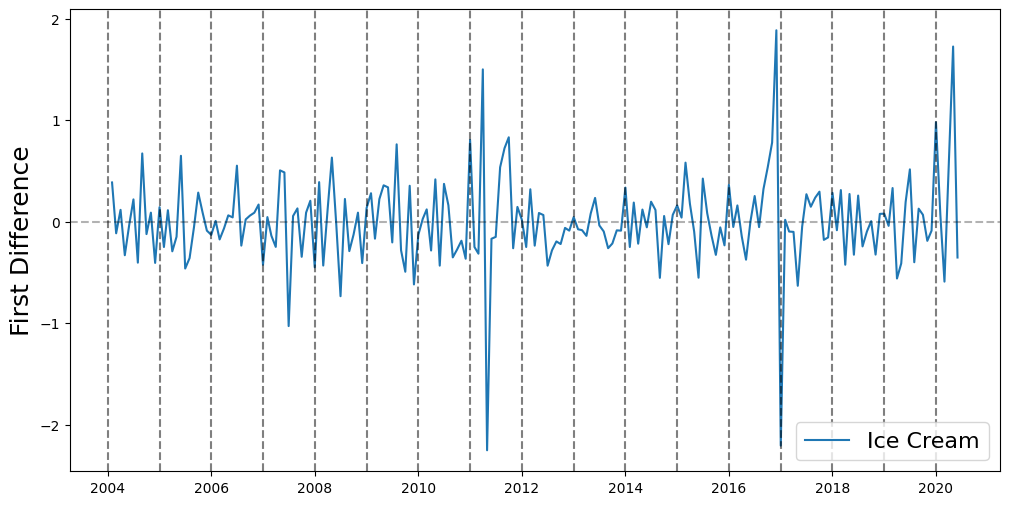

In [466]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

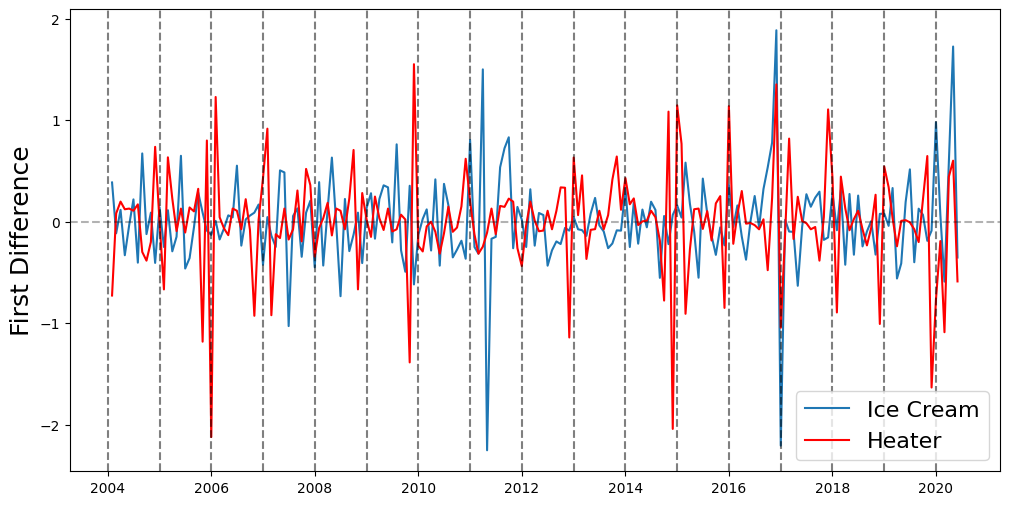

In [467]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# PACF - Heater

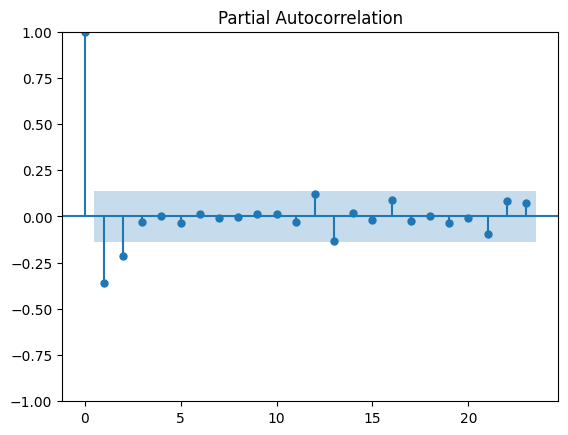

In [468]:
plot_pacf(ice_cream_heater_df['heater'])
plt.show()

## So consider an AR(2)

# Correlation between "heater" and lagged "ice cream"

In [469]:
for lag in range(1, 14):
    heater_series = ice_cream_heater_df['heater'].iloc[lag:]
    lagged_ice_cream_series = ice_cream_heater_df['ice cream'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(heater_series, lagged_ice_cream_series))
    print('------')

Lag: 1
PearsonRResult(statistic=np.float64(-0.03154450742591562), pvalue=np.float64(0.6607284991749419))
------
Lag: 2
PearsonRResult(statistic=np.float64(-0.09872703210944635), pvalue=np.float64(0.16970841905089737))
------
Lag: 3
PearsonRResult(statistic=np.float64(-0.001783855378923574), pvalue=np.float64(0.9803056762960979))
------
Lag: 4
PearsonRResult(statistic=np.float64(0.06023971859825543), pvalue=np.float64(0.4052979832528627))
------
Lag: 5
PearsonRResult(statistic=np.float64(-0.05403486448015027), pvalue=np.float64(0.45664426275057074))
------
Lag: 6
PearsonRResult(statistic=np.float64(0.06461183026553835), pvalue=np.float64(0.3745300043445426))
------
Lag: 7
PearsonRResult(statistic=np.float64(-0.04949334618415865), pvalue=np.float64(0.49768766857620594))
------
Lag: 8
PearsonRResult(statistic=np.float64(0.07890837135977341), pvalue=np.float64(0.28045489704330734))
------
Lag: 9
PearsonRResult(statistic=np.float64(-0.05323501699600429), pvalue=np.float64(0.4681034202228073

# Fit a VAR Model

In [470]:
ice_cream_heater_df = ice_cream_heater_df[['ice cream', 'heater']]

In [471]:
model = VAR(ice_cream_heater_df)

In [472]:
model_fit = model.fit(maxlags=13)

In [473]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jun, 2025
Time:                     16:40:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation ice cream
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.016054         0.034105           -0.471           0.638
L1.ice cream         -0.287811         0.079633           -3.614           0.000
L1.heater            -0.121251         0.073673         

# So our final model is:

$$
\hat{h}_t = - 0.41h_{t-1} - 0.19h_{t-2} + 0.2i_{t-13}
$$